# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
from tqdm.notebook import tqdm
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-12 15:54:13.713612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741794853.722191   54719 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741794853.724811   54719 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741794853.734446   54719 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741794853.734458   54719 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741794853.734460   54719 computation_placer.cc:177] computation placer alr

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [4]:
from utils.visualization_funcs import plot_random_images_bbox

In [5]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [7]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [8]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)


## Dataset Download from Roboflow

In [9]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("tensorflow")      

## Load images from directory

In [10]:
from utils.prepare_dataset import AnnotationProcessor

prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6930, 6930, 6930)

In [11]:
train_bboxes[0]

array([[0.57916667, 0.33333333, 0.75833333, 0.425     ],
       [0.5375    , 0.275     , 0.82916667, 0.5125    ],
       [0.57083333, 0.32083333, 0.76666667, 0.45416667]])

## Rebalance dataset by Down sempling to dataset with min images

In [12]:
# rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets(augment=False)
# len(train_images), len(train_class_ids), len(train_bboxes)

In [13]:
train_class_ids[1]

[1]

In [14]:
import keras
def pad_cls_id_bbx(class_id_list, bbox_list):
    padded_class_ids = keras.preprocessing.sequence.pad_sequences(
    class_id_list, padding='post', dtype='int32')
    padded_bbx = keras.preprocessing.sequence.pad_sequences(
        bbox_list, padding='post', dtype='float32')
    
    return padded_class_ids, padded_bbx

In [15]:
padded_class_ids, padded_bbx = pad_cls_id_bbx(train_class_ids, train_bboxes)
padded_bbx[1], len(padded_bbx)

(array([[0.5208333 , 0.51666665, 0.6791667 , 0.6125    ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 6930)

In [16]:
padded_class_ids[1], len(padded_class_ids)

(array([1, 0, 0], dtype=int32), 6930)

In [17]:
train_datasets = tf.data.Dataset.from_tensor_slices(
    (train_images, padded_class_ids, padded_bbx))
del train_images, train_class_ids, train_bboxes, padded_class_ids, padded_bbx
len(train_datasets)

I0000 00:00:1741794867.880907   54719 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7161 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


6930

In [18]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image, class_ids, bbox):
    tf_image = load_image(image)
    multi_hot = tf.reduce_max(
    tf.one_hot(tf.cast(class_ids, tf.int32), NUM_CLASSES), 
    axis=0
)  # Shape: (NUM_CLASSES,)
    return  tf_image, (multi_hot, bbox)

def preprocess(images, classes):
    processed_image = tf.keras.applications.resnet.preprocess_input(images)
    return processed_image, classes

### Augmentation 

In [19]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomSaturation(0.1),
    layers.RandomHue(0.1)
])

In [20]:
train_ds = train_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE) 
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x,y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
for batch in train_ds.take(1):
    image, (class_id, bbx) = batch
    print(image.shape, class_id, bbx.shape)
    print(image.dtype, class_id.dtype, bbx.dtype)
    print(bbx)

(240, 240, 3) tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32) (3, 4)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
tf.Tensor(
[[0.57916665 0.33333334 0.7583333  0.425     ]
 [0.5375     0.275      0.82916665 0.5125    ]
 [0.5708333  0.32083333 0.76666665 0.45416668]], shape=(3, 4), dtype=float32)


2025-03-12 15:54:28.470036: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
train_ds = train_ds.shuffle(buffer_size=train_datasets.cardinality().numpy(), reshuffle_each_iteration=True)\
                                .batch(BATCH_SIZE)\
                                .prefetch(tf.data.AUTOTUNE)

In [23]:
for batch in train_ds.take(1):
    image, (class_id, bbx) = batch
    print(image.numpy().min(), image.numpy().max())
    print(class_id, bbx)

0.0 255.0
tf.Tensor(
[[1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]], shape=(16, 3), dtype=float32) tf.Tensor(
[[[0.33333334 0.28333333 0.5625     0.46666667]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]

 [[0.59583336 0.375      0.65833336 0.45      ]
  [0.49583334 0.2875     0.80833334 0.475     ]
  [0.56666666 0.32916668 0.75       0.47083333]]

 [[0.5        0.50416666 0.6458333  0.625     ]
  [0.44583333 0.45833334 0.67083335 0.6333333 ]
  [0.45       0.5083333  0.65       0.625     ]]

 [[0.25833333 0.5083333  0.37916666 0.57916665]
  [0.22916667 0.4875     0.5125     0.70416665]
  [0.27083334 0.49166667 0.38333333 0.57916665]]

 [[0.62916666 0.49166667 0.8208333  0.65833336]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]

 [[0.74583334 

2025-03-12 15:54:33.732323: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [24]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1980, 1980, 1980)

In [25]:
valid_padded_class_ids, valid_padded_bbx = pad_cls_id_bbx(valid_class_ids, valid_bboxes)

In [26]:
val_datasets = tf.data.Dataset.from_tensor_slices((valid_image_paths,
                                               valid_padded_class_ids,
                                               valid_padded_bbx))

valid_ds = val_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [27]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(cls.shape,bbx.shape)

(16, 3) (16, 3, 4)


## Define ResNet50 Model

In [28]:
import keras
input_shape = (IMG_SIZE, IMG_SIZE, 3)
### Define ResNet50 as a Feature Extractor
def feature_extractor(inputs)-> tf.keras.Model:
    resnet50 = tf.keras.applications.ResNet50(
        include_top = False, 
        weights = "imagenet",
        input_shape = input_shape,    
        input_tensor=inputs
    )
    resnet50.trainable = True
    for layer in resnet50.layers[:140]: #example number of layers to freeze
        layer.trainable = False
    feature_extractor = resnet50.output
    return feature_extractor


### Define Dense Layers
def dense_layers(features)->tf.keras.Layer:
    x = keras.layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu')(features) # 1x1 conv
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=1024, activation='relu', kernel_regularizer='l2')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=512, activation='relu', kernel_regularizer='l2')(x)
    return x

### Define Bounding Box Regression
def bounding_box_regression(x)->tf.keras.Layer:
    bbox_shape=4
    bbox_reg_output = tf.keras.layers.Dense(units=bbox_shape*NUM_CLASSES, name='_bounding_box', activation='linear')(x)
    reshape_bbox = tf.keras.layers.Reshape(
        (NUM_CLASSES, 4),  # Not hard-coded
        name='bounding_box'
    )(bbox_reg_output)
    return reshape_bbox

###Define Classifier Layer
def classifer(inputs)->tf.keras.Model:
    return tf.keras.layers.Dense(units=NUM_CLASSES, activation='sigmoid', name = 'classification')(inputs)

def final_model()->tf.keras.Model:
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    _feature_extractor = feature_extractor(inputs)
   
    dense_output = dense_layers(_feature_extractor)

    bounding_box_regression_output = bounding_box_regression(dense_output)

    classification_output = classifer(dense_output)

    return tf.keras.Model(inputs=inputs, 
                          outputs=[classification_output, 
                                   bounding_box_regression_output])

In [29]:
def mobv2_feature_extractor(inputs):
    
    inputs = tf.keras.applications.mobilenet.preprocess_input(inputs)

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)

    # return the feature_extractor
    return feature_extractor#.outputs

### Final Model

In [30]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted'),
]

### Define  Callbacks

In [31]:
import os

to_monitor = 'val_loss'
mode = 'min'
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=2, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-6,
                                            verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "ckpt_{epoch}.keras") ,
                                        save_weights_only=False,
                                        save_best_only=True,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
                                        
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=10,
                                    mode=mode, 
                                    restore_best_weights=True),

]

### Define Optimizer

In [32]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, use_ema=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, clipvalue=1.0)

# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, clipvalue=1.0)
optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

## Model Building and Compilation

In [33]:
import tensorflow as tf

def iou_loss(y_true, y_pred):  # Assuming y_true and y_pred are (batch_size, 4)
    # y_true = y_true[0]
    # y_pred = tf.reshape(y_pred, ( 3, 4))
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast to float32

    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    x_max_true = y_true[..., 2]
    y_max_true = y_true[..., 3]

    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    x_max_pred = y_pred[..., 2]
    y_max_pred = y_pred[..., 3]

    area_true = (x_max_true - x_true) * (y_max_true - y_true_)
    area_pred = (x_max_pred - x_pred) * (y_max_pred - y_pred_)

    x_intersect = tf.maximum(x_true, x_pred)
    y_intersect = tf.maximum(y_true_, y_pred_)
    x_max_intersect = tf.minimum(x_max_true, x_max_pred)
    y_max_intersect = tf.minimum(y_max_true, y_max_pred)

    area_intersect = tf.maximum(0.0, x_max_intersect - x_intersect) * tf.maximum(0.0, y_max_intersect - y_intersect) # avoid negative values
    iou = area_intersect / (area_true + area_pred - area_intersect + 1e-7)  # Add small epsilon for numerical stability
    return 1.0 - iou  # We want to *minimize* the loss

def iou_metric(y_true, y_pred):  # No negation for metric
    # y_true = y_true[0]
    # y_pred = tf.reshape(y_pred, (3, 4))
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast to float32

    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    x_max_true = y_true[..., 2]
    y_max_true = y_true[..., 3]

    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    x_max_pred = y_pred[..., 2]
    y_max_pred = y_pred[..., 3]

    area_true = (x_max_true - x_true) * (y_max_true - y_true_)
    area_pred = (x_max_pred - x_pred) * (y_max_pred - y_pred_)

    x_intersect = tf.maximum(x_true, x_pred)
    y_intersect = tf.maximum(y_true_, y_pred_)
    x_max_intersect = tf.minimum(x_max_true, x_max_pred)
    y_max_intersect = tf.minimum(y_max_true, y_max_pred)

    area_intersect = tf.maximum(0.0, x_max_intersect - x_intersect) * tf.maximum(0.0, y_max_intersect - y_intersect) # avoid negative values
    iou = area_intersect / (area_true + area_pred - area_intersect + 1e-7)  # Add small epsilon for numerical stability
    return iou  # Return IoU directly for metric

def bounding_box_loss(y_true, y_pred):
    # Reshape the output to (batch_size, 3, 4)
    y_pred = tf.reshape(y_pred, (-1, 3, 4))
    #y_true should be of shape (batch_size, 3, 4)
    loss = 0
    for tr_bb, pr_bb in zip(y_true, y_pred):
        loss += tf.keras.losses.MeanSquaredError()(tr_bb[0, :], pr_bb[0,:])
    return loss

In [34]:
tf.keras.backend.clear_session()

model = final_model()
# model.compile(
#     optimizer=optimizer,
#     loss={'classification': 'binary_crossentropy', 'bounding_box': iou_loss},
#     metrics={'classification': METRICS, 'bounding_box': iou_metric})  # Use IoU metric
model.compile(
    optimizer=optimizer,
    loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=False), 'bounding_box': tf.keras.losses.MeanSquaredError()},
    metrics={'classification': METRICS, 'bounding_box': 'mse'})  # Use IoU metric


In [35]:
# model.summary()

### Train and Validate the model

In [36]:
EPOCHS = 3

In [37]:
import mlflow

mlflow.set_experiment("/brain-tumor-resnet50")
mlflow.tensorflow.autolog(log_models=True, log_datasets=False)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks],
)

2025/03/12 15:54:38 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
2025/03/12 15:54:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '250af8a1a18b494685f0b570b6867433', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/3


I0000 00:00:1741794891.449817   54971 service.cc:152] XLA service 0x705db8002130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741794891.449839   54971 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-12 15:54:51.742304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741794893.110275   54971 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/434 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - bounding_box_loss: 0.2413 - bounding_box_mse: 0.2413 - classification_AUC: 0.1250 - classification_f1_score: 0.3963 - classification_loss: 0.6932 - classification_precision: 0.8379 - classification_recall: 0.4958 - loss: 11.8425   

I0000 00:00:1741794897.867859   54971 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - bounding_box_loss: 0.0987 - bounding_box_mse: 0.0987 - classification_AUC: 0.3980 - classification_f1_score: 0.5002 - classification_loss: 0.3317 - classification_precision: 0.9020 - classification_recall: 0.9361 - loss: 8.2253
Epoch 1: val_loss improved from inf to 2.39127, saving model to output/checkpoints/ckpt_1.keras


434/434 ━━━━━━━━━━━━━━━━━━━━ 48s 68ms/step - bounding_box_loss: 0.0987 - bounding_box_mse: 0.0987 - classification_AUC: 0.3981 - classification_f1_score: 0.5001 - classification_loss: 0.3316 - classification_precision: 0.9020 - classification_recall: 0.9361 - loss: 8.2197 - val_bounding_box_loss: 0.0572 - val_bounding_box_mse: 0.0572 - val_classification_AUC: 0.5261 - val_classification_f1_score: 0.4597 - val_classification_loss: 0.2558 - val_classification_precision: 0.8767 - val_classification_recall: 0.9975 - val_loss: 2.3913 - learning_rate: 1.0000e-04
Epoch 2/3
433/434 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - bounding_box_loss: 0.0496 - bounding_box_mse: 0.0496 - classification_AUC: 0.5297 - classification_f1_score: 0.4338 - classification_loss: 0.2015 - classification_precision: 0.9370 - classification_recall: 0.9561 - loss: 1.6785
Epoch 2: val_loss improved from 2.39127 to 0.61729, saving model to output/checkpoints/ckpt_2.keras


434/434 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - bounding_box_loss: 0.0496 - bounding_box_mse: 0.0496 - classification_AUC: 0.5297 - classification_f1_score: 0.4337 - classification_loss: 0.2015 - classification_precision: 0.9370 - classification_recall: 0.9561 - loss: 1.6764 - val_bounding_box_loss: 0.0493 - val_bounding_box_mse: 0.0493 - val_classification_AUC: 0.5342 - val_classification_f1_score: 0.3845 - val_classification_loss: 0.2138 - val_classification_precision: 0.9250 - val_classification_recall: 0.9554 - val_loss: 0.6173 - learning_rate: 1.0000e-04
Epoch 3/3
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 0.0410 - bounding_box_mse: 0.0410 - classification_AUC: 0.5405 - classification_f1_score: 0.3929 - classification_loss: 0.1707 - classification_precision: 0.9612 - classification_recall: 0.9579 - loss: 0.4661
Epoch 3: val_loss improved from 0.61729 to 0.40362, saving model to output/checkpoints/ckpt_3.keras


434/434 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - bounding_box_loss: 0.0410 - bounding_box_mse: 0.0410 - classification_AUC: 0.5406 - classification_f1_score: 0.3928 - classification_loss: 0.1707 - classification_precision: 0.9612 - classification_recall: 0.9579 - loss: 0.4659 - val_bounding_box_loss: 0.0496 - val_bounding_box_mse: 0.0496 - val_classification_AUC: 0.5529 - val_classification_f1_score: 0.3842 - val_classification_loss: 0.2646 - val_classification_precision: 0.8865 - val_classification_recall: 0.9946 - val_loss: 0.4036 - learning_rate: 1.0000e-04


2025-03-12 15:56:18.603404: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2025/03/12 15:56:21 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/12 15:56:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsf_t8gm4/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/12 15:56:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


## Model Evaluation

### Testing Datasets setup

In [38]:

prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(990, 990, 990)

In [39]:
test_padded_class_ids, test_padded_bbx = pad_cls_id_bbx(test_class_ids, test_bboxes)

In [40]:
test_datasets = tf.data.Dataset.from_tensor_slices((test_image_paths,
                                               test_padded_class_ids,
                                               test_padded_bbx))

test_ds = test_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                . map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                .prefetch(tf.data.AUTOTUNE)

In [41]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
print("Testing accuracy: ", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - bounding_box_loss: 0.0662 - bounding_box_mse: 0.0662 - classification_AUC: 0.2734 - classification_f1_score: 0.4000 - classification_loss: 0.3284 - classification_precision: 0.8511 - classification_recall: 1.0000 - loss: 0.4835
Testing accuracy:  {'bounding_box_loss': 0.06615719199180603, 'bounding_box_mse': 0.06615719199180603, 'classification_AUC': 0.2734375, 'classification_f1_score': 0.4000000059604645, 'classification_loss': 0.32837778329849243, 'classification_precision': 0.8510638475418091, 'classification_recall': 1.0, 'loss': 0.4835153818130493}


In [42]:
results

{'bounding_box_loss': 0.06615719199180603,
 'bounding_box_mse': 0.06615719199180603,
 'classification_AUC': 0.2734375,
 'classification_f1_score': 0.4000000059604645,
 'classification_loss': 0.32837778329849243,
 'classification_precision': 0.8510638475418091,
 'classification_recall': 1.0,
 'loss': 0.4835153818130493}

In [43]:
def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")
  plt.legend([metric_name, 'val_' + metric_name])
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

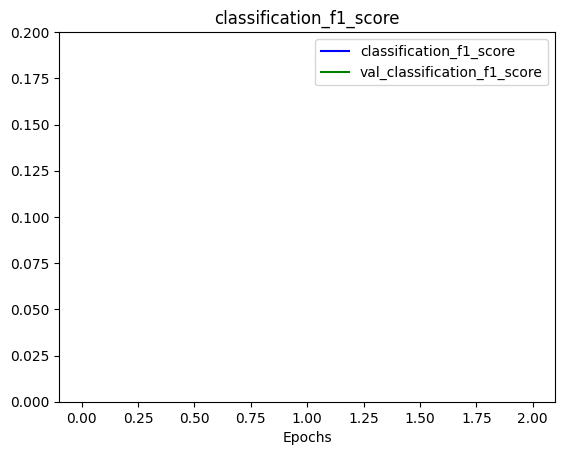

In [44]:
plot_metrics("loss", "val_loss", ylim=0.2)
plot_metrics("classification_f1_score", "classification_f1_score", ylim=0.2)

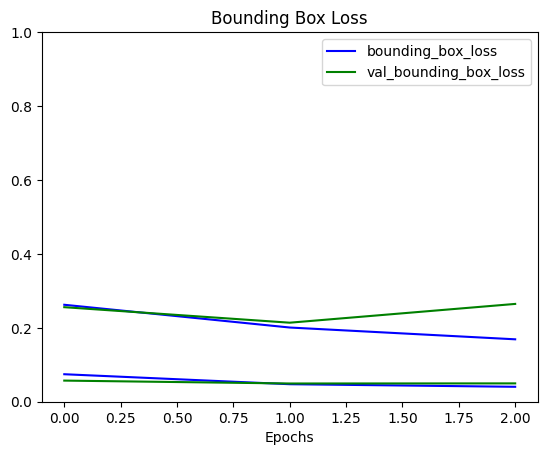

In [45]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")